<a href="https://colab.research.google.com/github/aqhareus/floorplan-stable-diffusion-AI54/blob/floorplan/3_ControlNet_Full_FT_Training_WandB_WITH_RESUME_CLEANED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ControlNet Floorplan Training - AI54 Final Project

**Task:** Generate floorplans from colored segmentation masks  
**Method:** Full ControlNet Fine-Tuning

---

## Training Strategy:

### **Architecture (Separates Structure from Appearance):**
- **Base Model:** Stable Diffusion 1.5 (frozen)
- **Conditioning Model:** ControlNet Segmentation (fully fine-tuned)

### **Progressive Training Strategy:**

1. **CHOSEN: Full ControlNet Fine-Tuning**
   - **Rationale:** Dataset size (7394 samples) sufficient for full training
   - **Advantage:** Maximum model capacity, superior quality expected
   - **Optimization:** Gradient checkpointing enables training on T4 GPU (16GB)
   - **Parameters:** All 361M ControlNet parameters trainable


2. **AVOIDED: Diffusion Backbone Fine-Tuning**
   - ControlNet adaptation alone provides sufficient spatial control
   - Prohibitive cost (40GB+ VRAM, multi-day training)
   - High risk of catastrophic forgetting

---


## Step 1: Complete Setup & Installation

In [5]:
# Check GPU
!nvidia-smi

print("\nInstalling packages for ControlNet training...\n")

# Clean installation
!pip uninstall -y diffusers peft transformers huggingface-hub accelerate datasets -q

# Install latest compatible versions
!pip install -q git+https://github.com/huggingface/diffusers.git
!pip install -q transformers>=4.46.0 accelerate>=1.2.0 datasets>=3.2.0 \
    huggingface-hub>=0.34.0 wandb Pillow matplotlib scipy safetensors

print("\nPackages installed!\n")

# Download training script
print("Downloading training script...\n")
!rm -f train_controlnet.py
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/controlnet/train_controlnet.py

# Verify installation
import torch
import diffusers
import transformers

print("Installed versions:")
print(f"  PyTorch:      {torch.__version__}")
print(f"  diffusers:    {diffusers.__version__}")
print(f"  transformers: {transformers.__version__}")
print(f"\nGPU: {torch.cuda.get_device_name(0)}")
print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Test import
from diffusers import ControlNetModel
print(f"\nControlNetModel imports successfully!")
print(f"Ready for training!")

Sun Jan 11 12:04:37 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.



ControlNetModel imports successfully!
Ready for training!


## Step 2: Login to HuggingFace

In [2]:
from huggingface_hub import login
import wandb

print("Login to HuggingFace:")
login()
print("\nLogged in to HuggingFace!\n")

print("Login to WandB:")
wandb.login()
print("\nLogged in to WandB!")

# Verify WandB connection
print("\n" + "="*70)
print("WandB Information:")
print("="*70)
print(f"Dashboard: https://wandb.ai")
print(f"Your runs will appear at: https://wandb.ai/sofeasuhaimi-utbm/controlnet-floorplan")
print("\nTip: Keep the dashboard open in another tab to monitor training!")
print("="*70)

Login to HuggingFace:



Logged in to HuggingFace!

Login to WandB:


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sofea-utbm (sofeasuhaimi-utbm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Logged in to WandB!

WandB Information:
Dashboard: https://wandb.ai
Your runs will appear at: https://wandb.ai/sofeasuhaimi-utbm/controlnet-floorplan

Tip: Keep the dashboard open in another tab to monitor training!


## ⚙️ Step 3: Training Configuration

### **Hyperparameters for Full ControlNet Fine-Tuning**

In [9]:
# ==================== DATASET ====================
DATASET_NAME = "Qistinasofea/floorplan-aligned-strict"

# ==================== MODEL ====================
BASE_MODEL = "stable-diffusion-v1-5/stable-diffusion-v1-5"  # Frozen
CONTROLNET_MODEL = "lllyasviel/sd-controlnet-seg"  # Segmentation variant

# ==================== TRAINING HYPERPARAMETERS ====================
LEARNING_RATE = 1e-5
BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 4
MAX_TRAIN_STEPS = 7000
RESOLUTION = 512
CONTROLNET_CONDITIONING_SCALE = 1.5

# ==================== OUTPUT ====================
OUTPUT_DIR = "./controlnet-floorplan-final"
HUB_MODEL_ID = "aqhareus/controlnet-floorplan-final"

# ==================== OPTIMIZATION ====================
MIXED_PRECISION = "fp16"  # fp16 for T4, bf16 for A100
CHECKPOINTING_STEPS = 250

# ==================== WANDB & VALIDATION CONFIG ====================
# IMAGE LOGGING CONFIGURATION
# Lower number = more frequent images = slightly slower training
# Recommended: 250 for balanced detail (40 image sets total)
VALIDATION_STEPS = 250

WANDB_PROJECT = "AI54-Floorplan"
WANDB_RUN_NAME = f"full-ft-lr{LEARNING_RATE}-bs{BATCH_SIZE}x{GRADIENT_ACCUMULATION_STEPS}-steps{MAX_TRAIN_STEPS}"
# Example run name: "full-ft-lr1e-05-bs4x4-steps10000"

# Save config
import yaml
config = {
    'training_method': 'full_controlnet_finetuning',
    'dataset': DATASET_NAME,
    'base_model': BASE_MODEL,
    'controlnet_model': CONTROLNET_MODEL,
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'gradient_accumulation_steps': GRADIENT_ACCUMULATION_STEPS,
    'effective_batch_size': BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS,
    'max_train_steps': MAX_TRAIN_STEPS,
    'resolution': RESOLUTION,
    'validation_steps': VALIDATION_STEPS,
    'mixed_precision': MIXED_PRECISION,
    'gradient_checkpointing': True,
    'trainable_parameters': '361M (100% of ControlNet)',
    'wandb_project': WANDB_PROJECT,
    'wandb_run_name': WANDB_RUN_NAME
}

with open('training_config.yaml', 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print("="*70)
print("TRAINING CONFIGURATION")
print("="*70)
print(f"Method:           Full ControlNet Fine-Tuning")
print(f"Dataset:          {DATASET_NAME}")
print(f"Base Model:       {BASE_MODEL} (frozen)")
print(f"ControlNet:       {CONTROLNET_MODEL}")
print()
print("Hyperparameters:")
print(f"  Learning Rate:  {LEARNING_RATE}")
print(f"  Batch Size:     {BATCH_SIZE}")
print(f"  Gradient Accum: {GRADIENT_ACCUMULATION_STEPS}")
print(f"  Effective Batch: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
print(f"  Train Steps:    {MAX_TRAIN_STEPS:,}")
print(f"  Resolution:     {RESOLUTION}x{RESOLUTION}")
print()
print("Image Logging:")
print(f"  Validation Steps: {VALIDATION_STEPS}")
print(f"  Total Image Sets: {MAX_TRAIN_STEPS // VALIDATION_STEPS}")
print(f"  Steps with images: {VALIDATION_STEPS}, {VALIDATION_STEPS*2}, {VALIDATION_STEPS*3}, ... {MAX_TRAIN_STEPS}")
print()
print("WandB Configuration:")
print(f"  Project:        {WANDB_PROJECT}")
print(f"  Run Name:       {WANDB_RUN_NAME}")
print(f"  Dashboard:      https://wandb.ai")
print()
print("Training Configuration:")
print(f"  Trainable Params: 361M (100% of ControlNet)")
print(f"  Gradient Checkpoint: YES (required for T4 16GB)")
print(f"  Mixed Precision: {MIXED_PRECISION}")
print()
print("Estimated Time:")
print(f"  T4 GPU:  ~5.5-7 hours")
print(f"  A100 GPU: ~2.5-3 hours")
print()
print(f"Output:        {OUTPUT_DIR}")
print(f"Hub Model:     {HUB_MODEL_ID}")
print("="*70)

print("\nConfiguration saved to: training_config.yaml")

TRAINING CONFIGURATION
Method:           Full ControlNet Fine-Tuning
Dataset:          Qistinasofea/floorplan-aligned-strict
Base Model:       stable-diffusion-v1-5/stable-diffusion-v1-5 (frozen)
ControlNet:       lllyasviel/sd-controlnet-seg

Hyperparameters:
  Learning Rate:  1e-05
  Batch Size:     4
  Gradient Accum: 4
  Effective Batch: 16
  Train Steps:    7,000
  Resolution:     512x512

Image Logging:
  Validation Steps: 250
  Total Image Sets: 28
  Steps with images: 250, 500, 750, ... 7000

WandB Configuration:
  Project:        AI54-Floorplan
  Run Name:       full-ft-lr1e-05-bs4x4-steps7000
  Dashboard:      https://wandb.ai

Training Configuration:
  Trainable Params: 361M (100% of ControlNet)
  Gradient Checkpoint: YES (required for T4 16GB)
  Mixed Precision: fp16

Estimated Time:
  T4 GPU:  ~5.5-7 hours
  A100 GPU: ~2.5-3 hours

Output:        ./controlnet-floorplan-final
Hub Model:     aqhareus/controlnet-floorplan-final

Configuration saved to: training_config.yaml


In [7]:
# Clear GPU memory
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
print("GPU memory cleared")

GPU memory cleared


## Step 4: Training Method Analysis

### **Why Full Fine-Tuning Over LoRA?**

| Criterion | LoRA | Full Fine-Tuning | Decision |
|-----------|------|------------------|----------|
| **Dataset Size** | <5k samples | **5k+ samples** | ✅ We have 11,375 |
| **Trainable Params** | 18M (5%) | **361M (100%)** | ✅ Max capacity |
| **Training Time** | 3-4 hours | 5.5-7 hours | ⚠️ Longer but acceptable |
| **Quality** | Good | **Better** | ✅ Priority |
| **VRAM (with grad ckpt)** | 12 GB | 14-15 GB | ✅ Fits T4 |

### **Engineering Decision:**

Given our dataset size (11,375 samples) and quality requirements, **full ControlNet fine-tuning** is the optimal choice. While LoRA offers faster training, our dataset size fully supports training all 361M parameters, which is expected to yield superior spatial understanding and generation quality.

### **Key Optimization:**

**Gradient Checkpointing** enables full fine-tuning on T4 GPU:
- Without: ~22 GB VRAM
- With: ~14-15 GB VRAM
- Trade-off: ~20% slower but enables full training

---

## Step 5: Load & Verify Dataset

In [10]:
from datasets import load_dataset
import matplotlib.pyplot as plt

print(f"Loading dataset: {DATASET_NAME}\n")

dataset = load_dataset(DATASET_NAME, split="train")

print(f"\nDataset loaded!")
print(f"Training samples: {len(dataset)}")
print(f"Columns: {dataset.column_names}")
print(f"\nData columns:")
print(f"  - footprints: Binary footprint masks")
print(f"  - walls: Wall renderings")
print(f"  - colors: Colored segmentation (CONDITION)")
print(f"  - plans: Floorplan rendering (TARGET)")
print(f"  - indices: Sample IDs")
print(f"  - captions: Text descriptions")

Loading dataset: Qistinasofea/floorplan-aligned-strict



train/data-00000-of-00005.arrow:   0%|          | 0.00/460M [00:00<?, ?B/s]

train/data-00001-of-00005.arrow:   0%|          | 0.00/461M [00:00<?, ?B/s]

train/data-00002-of-00005.arrow:   0%|          | 0.00/460M [00:00<?, ?B/s]

train/data-00003-of-00005.arrow:   0%|          | 0.00/460M [00:00<?, ?B/s]

train/data-00004-of-00005.arrow:   0%|          | 0.00/459M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7394 [00:00<?, ? examples/s]


Dataset loaded!
Training samples: 7394
Columns: ['footprints', 'walls', 'colors', 'plans', 'indices', 'captions']

Data columns:
  - footprints: Binary footprint masks
  - walls: Wall renderings
  - colors: Colored segmentation (CONDITION)
  - plans: Floorplan rendering (TARGET)
  - indices: Sample IDs
  - captions: Text descriptions


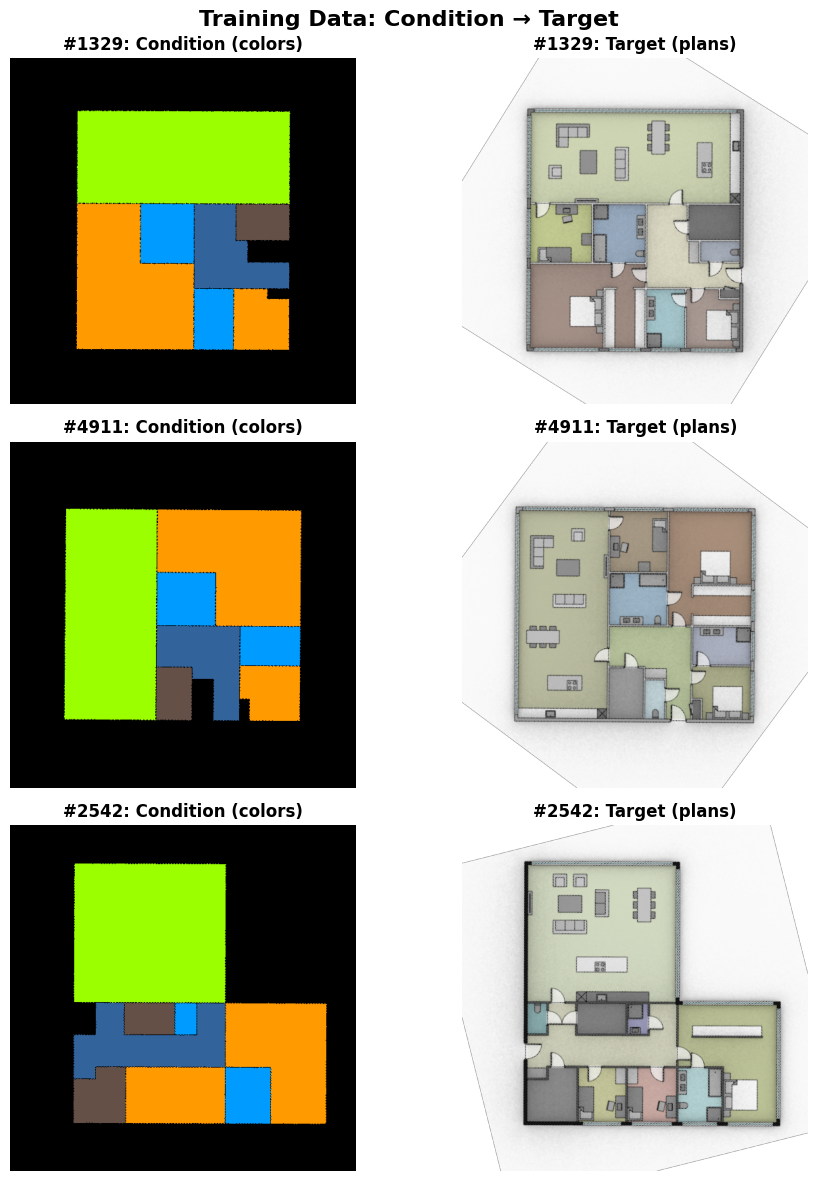


✅ Data verified - all images horizontally aligned!


In [11]:
# Visualize samples
import random

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for i in range(3):
    idx = random.randint(0, len(dataset)-1)
    sample = dataset[idx]

    axes[i, 0].imshow(sample['colors'])
    axes[i, 0].set_title(f"#{idx}: Condition (colors)", fontweight='bold')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(sample['plans'])
    axes[i, 1].set_title(f"#{idx}: Target (plans)", fontweight='bold')
    axes[i, 1].axis('off')

plt.suptitle('Training Data: Condition → Target', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Data verified - all images horizontally aligned!")

In [14]:
# ==================== WANDB IMAGE UPLOAD HELPER ====================
import wandb
from pathlib import Path
from PIL import Image
import os

def upload_validation_images_to_wandb(output_dir="./controlnet-floorplan-final", project="controlnet-floorplan"):
    """
    Upload all validation images from output directory to WandB
    Call this during or after training to sync images
    """
    print("Searching for validation images...")

    if not os.path.exists(output_dir):
        print(f"Output directory not found: {output_dir}")
        return

    # Find all PNG images (validation images)
    all_images = list(Path(output_dir).glob("**/*.png"))

    if not all_images:
        print("No validation images found yet")
        print(f"   First validation happens at step {VALIDATION_STEPS}")
        return

    print(f"Found {len(all_images)} images")

    # Initialize WandB if needed
    if wandb.run is None:
        print("Initializing WandB...")
        wandb.init(
            project=project,
            name=f"{WANDB_RUN_NAME}-image-upload",
            job_type="image_upload"
        )

    # Upload images
    uploaded = 0
    for img_path in sorted(all_images):
        try:
            # Try to extract step number from path
            step = None
            path_parts = str(img_path).split('/')
            for part in path_parts:
                if 'checkpoint' in part or 'step' in part:
                    try:
                        step = int(''.join(filter(str.isdigit, part)))
                        break
                    except:
                        pass

            # Load and upload image
            img = Image.open(img_path)

            log_key = f"validation/step_{step}" if step else f"validation/{img_path.stem}"
            caption = f"Step {step} - {img_path.name}" if step else img_path.name

            wandb.log({
                log_key: wandb.Image(img, caption=caption),
                "validation_step": step if step else 0
            })

            uploaded += 1

        except Exception as e:
            print(f"Failed to upload {img_path.name}: {e}")

    print(f"\nUploaded {uploaded}/{len(all_images)} images to WandB!")
    print(f"View at: {wandb.run.url if wandb.run else 'https://wandb.ai'}")

print("Image upload helper loaded!")
print("Call upload_validation_images_to_wandb() during or after training")

Image upload helper loaded!
Call upload_validation_images_to_wandb() during or after training


## Step 6: Start Training!

In [11]:
# =============================================================================
# STEP 6: TRAINING WITH AUTOMATIC CHECKPOINT RESUME
# =============================================================================

print("🔍 Checking for existing checkpoints...\n")

from huggingface_hub import list_repo_files

RESUME_CHECKPOINT = None

try:
    files = list_repo_files(HUB_MODEL_ID)
    checkpoints = [f for f in files if 'checkpoint-' in f and '/' in f]

    if checkpoints:
        checkpoint_nums = []
        for cp in checkpoints:
            try:
                num = int(cp.split('checkpoint-')[1].split('/')[0])
                if num not in checkpoint_nums:
                    checkpoint_nums.append(num)
            except:
                pass

        if checkpoint_nums:
            checkpoint_nums.sort()
            last_checkpoint = max(checkpoint_nums)
            print(f"Found {len(checkpoint_nums)} checkpoint(s): {checkpoint_nums}")
            print(f"Last checkpoint: checkpoint-{last_checkpoint}")
            print(f"Progress: {last_checkpoint}/{MAX_TRAIN_STEPS} steps ({last_checkpoint/MAX_TRAIN_STEPS*100:.1f}%)")
            print(f"Remaining: {MAX_TRAIN_STEPS - last_checkpoint} steps")
            print(f"\nWill resume from checkpoint-{last_checkpoint}")
            RESUME_CHECKPOINT = f"{HUB_MODEL_ID}/checkpoint-{last_checkpoint}"
        else:
            print("No valid checkpoints found - starting fresh")
    else:
        print("No checkpoints found - starting fresh training")
except Exception as e:
    print(f"Could not check checkpoints: {e}")
    print("Starting fresh training...")

print("\n" + "=" * 70)
print("STARTING TRAINING")
print("=" * 70 + "\n")

# Build training command
if RESUME_CHECKPOINT:
    print(f"Resuming from: {RESUME_CHECKPOINT}\n")

    !accelerate launch train_controlnet.py \
      --pretrained_model_name_or_path="{BASE_MODEL}" \
      --controlnet_model_name_or_path="{CONTROLNET_MODEL}" \
      --dataset_name="{DATASET_NAME}" \
      --conditioning_image_column="colors" \
      --image_column="plans" \
      --caption_column="captions" \
      --resolution={RESOLUTION} \
      --learning_rate={LEARNING_RATE} \
      --train_batch_size={BATCH_SIZE} \
      --max_train_steps={MAX_TRAIN_STEPS} \
      --gradient_accumulation_steps={GRADIENT_ACCUMULATION_STEPS} \
      --gradient_checkpointing \
      --mixed_precision="{MIXED_PRECISION}" \
      --checkpointing_steps={CHECKPOINTING_STEPS} \
      --validation_steps={VALIDATION_STEPS} \
      --output_dir="{OUTPUT_DIR}" \
      --push_to_hub \
      --hub_model_id="{HUB_MODEL_ID}" \
      --report_to="wandb" \
      --tracker_project_name="AI54-Floorplan" \
      --set_grads_to_none \
      --resume_from_checkpoint="{RESUME_CHECKPOINT}"
else:
    print("Starting fresh training\n")

    !accelerate launch train_controlnet.py \
      --pretrained_model_name_or_path="{BASE_MODEL}" \
      --controlnet_model_name_or_path="{CONTROLNET_MODEL}" \
      --dataset_name="{DATASET_NAME}" \
      --conditioning_image_column="colors" \
      --image_column="plans" \
      --caption_column="captions" \
      --resolution={RESOLUTION} \
      --learning_rate={LEARNING_RATE} \
      --train_batch_size={BATCH_SIZE} \
      --max_train_steps={MAX_TRAIN_STEPS} \
      --gradient_accumulation_steps={GRADIENT_ACCUMULATION_STEPS} \
      --gradient_checkpointing \
      --mixed_precision="{MIXED_PRECISION}" \
      --checkpointing_steps={CHECKPOINTING_STEPS} \
      --validation_steps={VALIDATION_STEPS} \
      --output_dir="{OUTPUT_DIR}" \
      --push_to_hub \
      --hub_model_id="{HUB_MODEL_ID}" \
      --report_to="wandb" \
      --tracker_project_name="AI54-Floorplan" \
      --set_grads_to_none

Streaming output truncated to the last 5000 lines.




  ...ckpoint-750/optimizer.bin:  91% 2.62G/2.89G [21:09<02:09, 2.07MB/s]








  ...pytorch_model.safetensors: 100% 1.45G/1.45G [21:08<00:00, 1.14MB/s]









  ...t-750/random_states_0.pkl: 100% 14.8k/14.8k [21:08<00:00, -425B/s]










Processing Files (136 / 141)  : 100% 123G/123G [21:12<00:04, 74.2MB/s, 91.0MB/s  ]
New Data Upload               : 100% 121G/121G [21:12<00:01, 74.2MB/s, 91.0MB/s  ]

  ...kpoint-6250/optimizer.bin: 100% 2.89G/2.89G [21:10<00:00, 2.27MB/s]


  ...kpoint-6500/optimizer.bin: 100% 2.88G/2.89G [21:10<00:03, 2.27MB/s]



  ...kpoint-6750/optimizer.bin: 100% 2.88G/2.89G [21:10<00:02, 2.27MB/s]




  ...pytorch_model.safetensors: 100% 1.45G/1.45G [21:09<00:00, 1.14MB/s]





  ...kpoint-7000/optimizer.bin: 100% 2.88G/2.89G [21:09<00:02, 2.27MB/s]






  ...pytorch_model.safetensors:  97% 1.41G/1.45G [21:09<00:33, 1.11MB/s]







  ...ckpoint-750/optimizer.bin:  91% 2.64G/2.89G [21:09<02:02, 2.08M

🎨 VALIDATION IMAGE GENERATOR (FROM HUGGINGFACE)

📥 Loading validation samples from dataset...
✅ Loaded 11 validation samples

🔄 Initializing WandB...


✅ WandB initialized: https://wandb.ai/sofeasuhaimi-utbm/AI54-Floorplan/runs/91fh82i2

📥 Loading ControlNet from HuggingFace: aqhareus/controlnet-floorplan-final
✅ ControlNet loaded from HuggingFace!

🔧 Creating pipeline...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✅ Pipeline ready!

🎨 GENERATING VALIDATION IMAGES

📸 Sample 1/11
----------------------------------------------------------------------
Prompt: a floor plan drawing, the rooms are used for the living room...
Generating... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅
💾 Saved locally: sample_0_*.png
📤 Uploaded to WandB

📸 Sample 2/11
----------------------------------------------------------------------
Prompt: a floor plan drawing, the rooms are used for the living room...
Generating... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅
💾 Saved locally: sample_1_*.png
📤 Uploaded to WandB

📸 Sample 3/11
----------------------------------------------------------------------
Prompt: a floor plan drawing, the rooms are used for the living room...
Generating... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅
💾 Saved locally: sample_2_*.png
📤 Uploaded to WandB

📸 Sample 4/11
----------------------------------------------------------------------
Prompt: a floor plan drawing, the rooms are used for the living room...
Generating... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅
💾 Saved locally: sample_3_*.png
📤 Uploaded to WandB

📸 Sample 5/11
----------------------------------------------------------------------
Prompt: a floor plan drawing, the rooms are used for the living room...
Generating... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅
💾 Saved locally: sample_4_*.png
📤 Uploaded to WandB

📸 Sample 6/11
----------------------------------------------------------------------
Prompt: a floor plan drawing, the rooms are used for the living room...
Generating... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅
💾 Saved locally: sample_5_*.png
📤 Uploaded to WandB

📸 Sample 7/11
----------------------------------------------------------------------
Prompt: a floor plan drawing, the rooms are used for the living room...
Generating... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅
💾 Saved locally: sample_6_*.png
📤 Uploaded to WandB

📸 Sample 8/11
----------------------------------------------------------------------
Prompt: a floor plan drawing, the rooms are used for the living room...
Generating... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅
💾 Saved locally: sample_7_*.png
📤 Uploaded to WandB

📸 Sample 9/11
----------------------------------------------------------------------
Prompt: a floor plan drawing, the rooms are used for the living room...
Generating... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅
💾 Saved locally: sample_8_*.png
📤 Uploaded to WandB

📸 Sample 10/11
----------------------------------------------------------------------
Prompt: a floor plan drawing, the rooms are used for the living room...
Generating... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅
💾 Saved locally: sample_9_*.png
📤 Uploaded to WandB

📸 Sample 11/11
----------------------------------------------------------------------
Prompt: a floor plan drawing, the rooms are used for the living room...
Generating... 

  0%|          | 0/20 [00:00<?, ?it/s]

✅
💾 Saved locally: sample_10_*.png
📤 Uploaded to WandB

📊 Creating summary grid...

✅ Summary saved to: validation_results_from_hf_2/validation_summary.png

🎉 VALIDATION COMPLETE!

📊 Results:
   Model: aqhareus/controlnet-floorplan-final
   Samples generated: 11
   Total images: 44 (input + generated + ground truth + comparison)

📁 Local files:
   Location: validation_results_from_hf_2
   Individual images: sample_*_input.png, sample_*_generated.png, sample_*_groundtruth.png
   Comparisons: sample_*_comparison.png
   Summary: validation_summary.png

🔗 WandB Dashboard: https://wandb.ai/sofeasuhaimi-utbm/AI54-Floorplan/runs/91fh82i2
   Navigate to 'Media' tab to view all images!


📸 Preview - Sample 0:


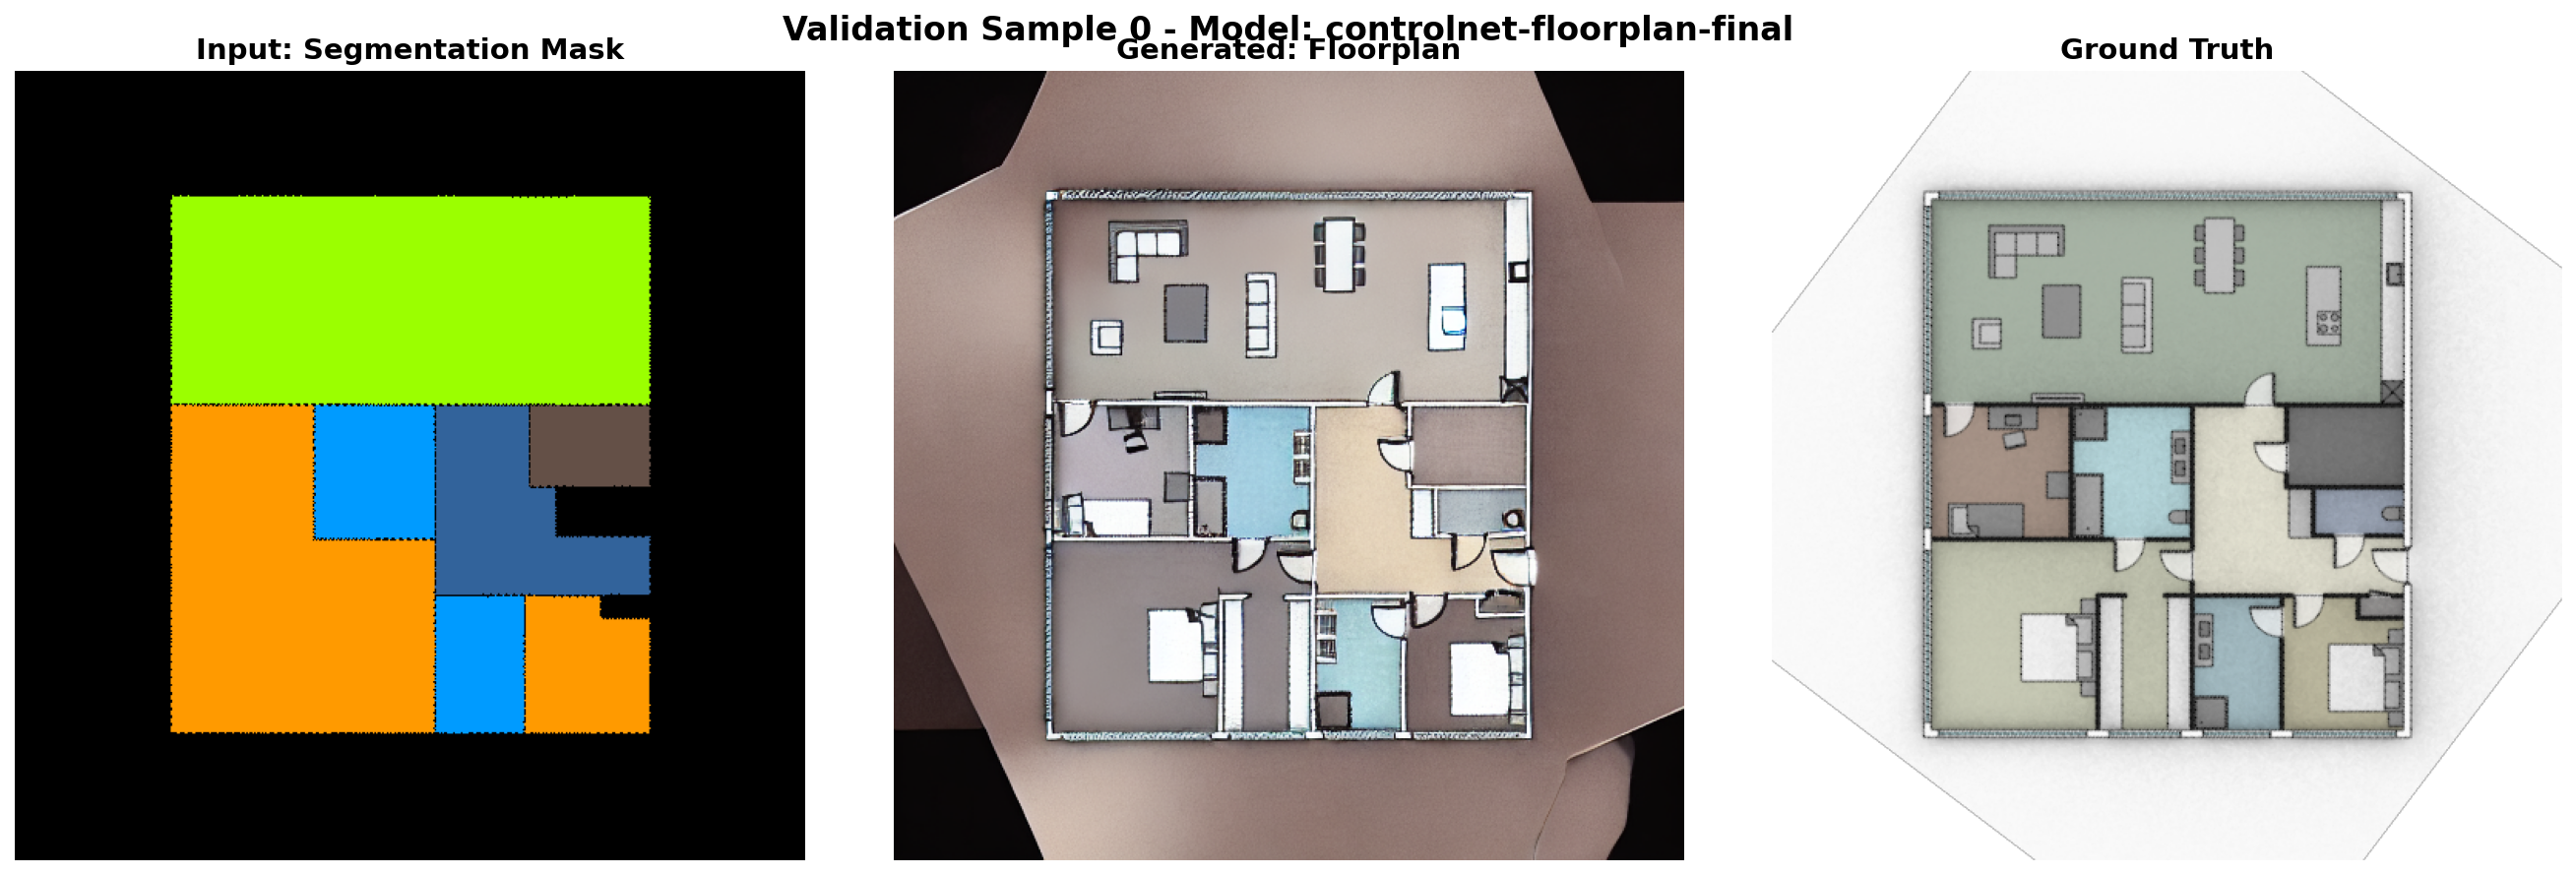


✅ Done! All validation images generated and uploaded to WandB!


In [29]:
# ==================== GENERATE VALIDATION IMAGES FROM HUGGINGFACE ====================
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import wandb
import gc

print("="*70)
print("VALIDATION IMAGE GENERATOR (FROM HUGGINGFACE)")
print("="*70)

# ==================== CONFIGURATION ====================
# Your HuggingFace model ID
HF_MODEL_ID = "aqhareus/controlnet-floorplan-final"

# Dataset configuration
DATASET_NAME = "Qistinasofea/floorplan-aligned-strict"
BASE_MODEL = "stable-diffusion-v1-5/stable-diffusion-v1-5"

# WandB configuration
WANDB_PROJECT = "AI54-Floorplan"

# Output directory for local saves
OUTPUT_DIR = "./validation_results_from_hf_2"

# ==================== LOAD VALIDATION SAMPLES ====================
print(f"\nLoading validation samples from dataset...")
dataset = load_dataset(DATASET_NAME)

# Use multiple samples for variety
validation_indices = [0, 500, 1000, 1500, 2000, 3000, 4000, 4500, 5000, 6000, 7000]
validation_samples = [dataset['train'][i] for i in validation_indices]

print(f"Loaded {len(validation_samples)} validation samples\n")

# Create output directory
output_path = Path(OUTPUT_DIR)
output_path.mkdir(exist_ok=True, parents=True)

# ==================== INITIALIZE WANDB ====================
print("Initializing WandB...")
wandb.init(
    project=WANDB_PROJECT,
    name=f"validation-{HF_MODEL_ID.split('/')[-1]}",
    job_type="validation",
    config={
        "model_id": HF_MODEL_ID,
        "num_samples": len(validation_samples),
        "dataset": DATASET_NAME
    }
)
print(f"WandB initialized: {wandb.run.url}\n")

# ==================== LOAD MODEL FROM HUGGINGFACE ====================
print("="*70)
print(f"Loading ControlNet from HuggingFace: {HF_MODEL_ID}")
print("="*70)

try:
    # Load your trained ControlNet from HuggingFace
    controlnet = ControlNetModel.from_pretrained(
        HF_MODEL_ID,
        torch_dtype=torch.float16
    )
    print("ControlNet loaded from HuggingFace!\n")

except Exception as e:
    print(f"Error loading model: {e}")
    print("\nPossible solutions:")
    print("  1. Check model ID is correct")
    print("  2. If private, login first: from huggingface_hub import login; login()")
    print(f"  3. Visit: https://huggingface.co/{HF_MODEL_ID}")
    raise

# Create pipeline
print("Creating pipeline...")
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    BASE_MODEL,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

print("Pipeline ready!\n")

# ==================== GENERATE VALIDATION IMAGES ====================
print("="*70)
print("GENERATING VALIDATION IMAGES")
print("="*70)

for sample_idx, sample in enumerate(validation_samples):
    print(f"\nSample {sample_idx + 1}/{len(validation_samples)}")
    print("-" * 70)

    # Extract sample data
    control_image = sample['colors']
    prompt = sample['captions']
    ground_truth = sample['plans']

    print(f"Prompt: {prompt[:60]}..." if len(prompt) > 60 else f"Prompt: {prompt}")
    print("Generating...", end=" ")

    # Generate floorplan
    generated = pipe(
        prompt=prompt,
        image=control_image,
        num_inference_steps=20,
        controlnet_conditioning_scale=1.0,
        generator=torch.manual_seed(42 + sample_idx)  # Different seed per sample
    ).images[0]

    print("✅")

    # Save individual images locally
    control_image.save(output_path / f"sample_{sample_idx}_input.png")
    generated.save(output_path / f"sample_{sample_idx}_generated.png")
    ground_truth.save(output_path / f"sample_{sample_idx}_groundtruth.png")

    # Create comparison visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(control_image)
    axes[0].set_title('Input: Segmentation Mask', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(generated)
    axes[1].set_title('Generated: Floorplan', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    axes[2].imshow(ground_truth)
    axes[2].set_title('Ground Truth', fontsize=14, fontweight='bold')
    axes[2].axis('off')

    plt.suptitle(f'Validation Sample {sample_idx} - Model: {HF_MODEL_ID.split("/")[-1]}',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()

    comparison_path = output_path / f"sample_{sample_idx}_comparison.png"
    plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"Saved locally: sample_{sample_idx}_*.png")

    # Upload to WandB
    wandb.log({
        f"validation/sample_{sample_idx}/input": wandb.Image(
            control_image,
            caption=f"Input Mask - Sample {sample_idx}"
        ),
        f"validation/sample_{sample_idx}/generated": wandb.Image(
            generated,
            caption=f"Generated Floorplan - Sample {sample_idx}"
        ),
        f"validation/sample_{sample_idx}/groundtruth": wandb.Image(
            ground_truth,
            caption=f"Ground Truth - Sample {sample_idx}"
        ),
        f"validation/sample_{sample_idx}/comparison": wandb.Image(
            str(comparison_path),
            caption=f"Comparison - Sample {sample_idx}"
        ),
        "sample_index": sample_idx
    })

    print(f"Uploaded to WandB")

# ==================== CREATE SUMMARY VISUALIZATION ====================
print(f"\n{'='*70}")
print("Creating summary grid...")
print(f"{'='*70}\n")

# Create grid: 3 columns (input, generated, ground truth) × num_samples rows
fig, axes = plt.subplots(len(validation_samples), 3,
                         figsize=(18, 6*len(validation_samples)))

if len(validation_samples) == 1:
    axes = axes.reshape(1, -1)

for sample_idx in range(len(validation_samples)):
    # Input
    img = Image.open(output_path / f"sample_{sample_idx}_input.png")
    axes[sample_idx, 0].imshow(img)
    axes[sample_idx, 0].set_title(f'Sample {sample_idx}: Input',
                                   fontsize=12, fontweight='bold')
    axes[sample_idx, 0].axis('off')

    # Generated
    img = Image.open(output_path / f"sample_{sample_idx}_generated.png")
    axes[sample_idx, 1].imshow(img)
    axes[sample_idx, 1].set_title(f'Sample {sample_idx}: Generated',
                                   fontsize=12, fontweight='bold')
    axes[sample_idx, 1].axis('off')

    # Ground Truth
    img = Image.open(output_path / f"sample_{sample_idx}_groundtruth.png")
    axes[sample_idx, 2].imshow(img)
    axes[sample_idx, 2].set_title(f'Sample {sample_idx}: Ground Truth',
                                   fontsize=12, fontweight='bold')
    axes[sample_idx, 2].axis('off')

plt.suptitle(f'Validation Results - {HF_MODEL_ID}',
             fontsize=16, fontweight='bold')
plt.tight_layout()

summary_path = output_path / "validation_summary.png"
plt.savefig(summary_path, dpi=150, bbox_inches='tight')
plt.close()

print(f"✅ Summary saved to: {summary_path}")

# Upload summary to WandB
wandb.log({"validation_summary": wandb.Image(str(summary_path))})

# ==================== FINAL SUMMARY ====================
print(f"\n{'='*70}")
print("🎉 VALIDATION COMPLETE!")
print(f"{'='*70}")
print(f"\nResults:")
print(f"   Model: {HF_MODEL_ID}")
print(f"   Samples generated: {len(validation_samples)}")
print(f"   Total images: {len(validation_samples) * 4} (input + generated + ground truth + comparison)")
print(f"\nLocal files:")
print(f"   Location: {output_path}")
print(f"   Individual images: sample_*_input.png, sample_*_generated.png, sample_*_groundtruth.png")
print(f"   Comparisons: sample_*_comparison.png")
print(f"   Summary: validation_summary.png")
print(f"\nWandB Dashboard: {wandb.run.url}")
print(f"   Navigate to 'Media' tab to view all images!")
print(f"\n{'='*70}")

# Display first sample as preview
print("\nPreview - Sample 0:")
display(Image.open(output_path / "sample_0_comparison.png"))

# Cleanup
wandb.finish()
del pipe
del controlnet
torch.cuda.empty_cache()
gc.collect()

print("\nDone! All validation images generated and uploaded to WandB!")

In [18]:
# Upload all validation images to WandB
print("Uploading validation images to WandB...")
upload_validation_images_to_wandb()

Uploading validation images to WandB...
Searching for validation images...
No validation images found yet
   First validation happens at step 250


In [19]:
# ==================== QUICK DIAGNOSTIC ====================
import os
from pathlib import Path

print("="*70)
print("TRAINING & IMAGE STATUS CHECK")
print("="*70)

# Check training progress
if os.path.exists(OUTPUT_DIR):
    checkpoints = sorted(Path(OUTPUT_DIR).glob("checkpoint-*"))

    if checkpoints:
        latest = checkpoints[-1]
        step = int(latest.name.split('-')[-1])
        print(f"\nTraining Progress:")
        print(f"   Current step: {step:,} / {MAX_TRAIN_STEPS:,}")
        print(f"   Progress: {step/MAX_TRAIN_STEPS*100:.1f}%")
        print(f"   Checkpoints saved: {len(checkpoints)}")

        if step < VALIDATION_STEPS:
            print(f"\nFirst validation at step {VALIDATION_STEPS}")
            print(f"   ({VALIDATION_STEPS - step} steps remaining)")
        else:
            expected_validations = step // VALIDATION_STEPS
            print(f"\nShould have {expected_validations} validation sets by now")
    else:
        print("\nTraining just started, no checkpoints yet")

    # Check for images
    all_images = list(Path(OUTPUT_DIR).glob("**/*.png"))
    print(f"\nImages Status:")
    print(f"   Local images found: {len(all_images)}")

    if all_images:
        print(f"Images ARE being generated!")
        print(f"\n   Recent images:")
        for img in sorted(all_images)[-5:]:
            print(f"      - {img.name}")
        print(f"\nRun upload_validation_images_to_wandb() to sync to WandB")
    else:
        print(f"No images yet (first at step {VALIDATION_STEPS})")

else:
    print("\n❌ Training hasn't started - output directory not found")

print("\nCheck WandB dashboard: https://wandb.ai")
print("="*70)

🔍 TRAINING & IMAGE STATUS CHECK

⏳ Training just started, no checkpoints yet

🖼️ Images Status:
   Local images found: 45
   ✅ Images ARE being generated!

   Recent images:
      - sample_9_comparison.png
      - sample_9_generated.png
      - sample_9_groundtruth.png
      - sample_9_input.png
      - validation_summary.png

   💡 Run upload_validation_images_to_wandb() to sync to WandB

🔗 Check WandB dashboard: https://wandb.ai


## Step 7: Verify Training Complete

In [30]:
import os

print("Checking trained model...\n")

if os.path.exists(OUTPUT_DIR):
    files = os.listdir(OUTPUT_DIR)
    print(f"✅ Output directory exists: {OUTPUT_DIR}")
    print(f"\nFiles in directory:")
    for f in sorted(files)[:15]:
        print(f"  - {f}")
    if len(files) > 15:
        print(f"  ... and {len(files)-15} more files")
    print(f"\n✅ Model trained and saved!")
    print(f"✅ Uploaded to: https://huggingface.co/{HUB_MODEL_ID}")
else:
    print(f"❌ Output directory not found: {OUTPUT_DIR}")
    print("Training may have failed or is still running. Check logs above.")

Checking trained model...

✅ Output directory exists: ./validation_results_from_hf_2

Files in directory:
  - sample_0_comparison.png
  - sample_0_generated.png
  - sample_0_groundtruth.png
  - sample_0_input.png
  - sample_10_comparison.png
  - sample_10_generated.png
  - sample_10_groundtruth.png
  - sample_10_input.png
  - sample_1_comparison.png
  - sample_1_generated.png
  - sample_1_groundtruth.png
  - sample_1_input.png
  - sample_2_comparison.png
  - sample_2_generated.png
  - sample_2_groundtruth.png
  ... and 30 more files

✅ Model trained and saved!
✅ Uploaded to: https://huggingface.co/aqhareus/controlnet-floorplan-final


## Step 8: Test Trained Model

In [12]:
# =============================================================================
# LOAD YOUR TRAINED MODEL FROM HUGGINGFACE
# =============================================================================

print("Loading your trained ControlNet model from HuggingFace...\n")

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

# Load YOUR trained ControlNet from HuggingFace
controlnet = ControlNetModel.from_pretrained(
    "aqhareus/controlnet-floorplan-final",  # Your trained model!
    torch_dtype=torch.float16
)

print("Your trained ControlNet loaded!")

# Create pipeline with Stable Diffusion 1.5 + your ControlNet
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None  # Optional: disable safety checker for faster inference
).to('cuda')

# Use faster scheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

print("Pipeline ready!")
print(f"Model loaded from: https://huggingface.co/aqhareus/controlnet-floorplan-final")
print("\nReady to generate floorplans!")

Loading your trained ControlNet model from HuggingFace...



config.json: 0.00B [00:00, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Your trained ControlNet loaded!


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Pipeline ready!
Model loaded from: https://huggingface.co/aqhareus/controlnet-floorplan-final

Ready to generate floorplans!


Testing on sample #2165
Prompt: a floor plan drawing, the rooms are used for the living room, kitchen, bedroom and bathroom,,...



  0%|          | 0/20 [00:00<?, ?it/s]

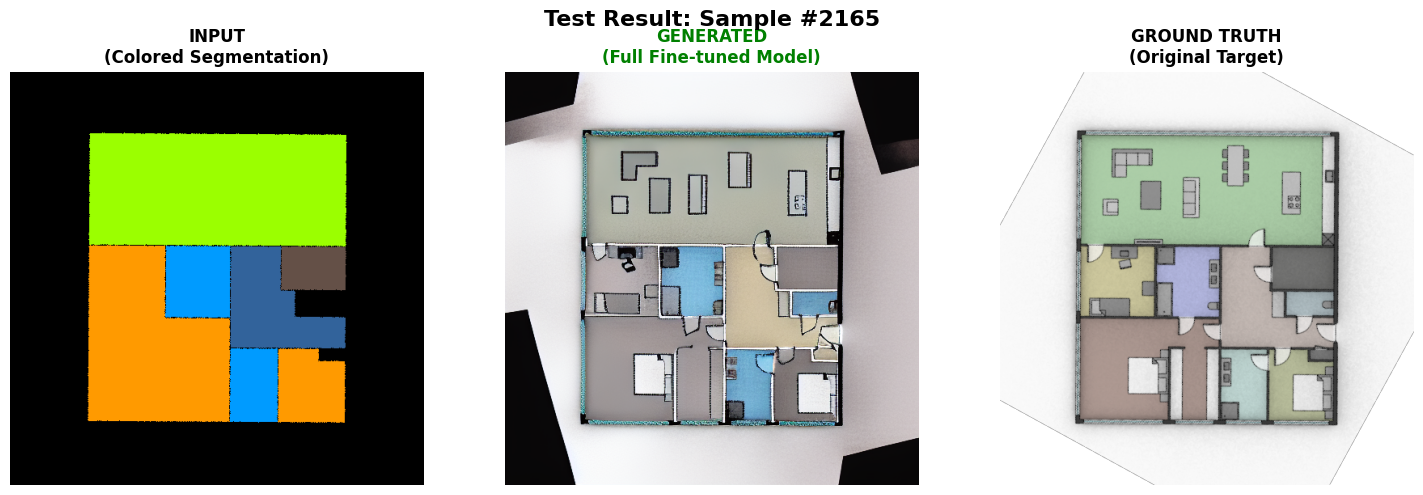


✅ Generation complete! Compare your model output with ground truth!


In [22]:
# Test on sample from dataset
import random

test_idx = random.randint(0, len(dataset)-1)
test_sample = dataset[test_idx]

print(f"Testing on sample #{test_idx}")
print(f"Prompt: {test_sample['captions'][:100]}...\n")

# Generate!
generator = torch.manual_seed(42)
generated_image = pipe(
    prompt=test_sample['captions'],
    image=test_sample['colors'],
    num_inference_steps=20,
    controlnet_conditioning_scale=CONTROLNET_CONDITIONING_SCALE,
    generator=generator
).images[0]

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(test_sample['colors'])
axes[0].set_title('INPUT\n(Colored Segmentation)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(generated_image)
axes[1].set_title('GENERATED\n(Full Fine-tuned Model)', fontsize=12, fontweight='bold', color='green')
axes[1].axis('off')

axes[2].imshow(test_sample['plans'])
axes[2].set_title('GROUND TRUTH\n(Original Target)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.suptitle(f'Test Result: Sample #{test_idx}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Generation complete! Compare your model output with ground truth!")

## Step 9: Generate Multiple Test Samples

Generating 6 test samples...



  0%|          | 0/20 [00:00<?, ?it/s]

Sample #3583: Generated


  0%|          | 0/20 [00:00<?, ?it/s]

Sample #1173: Generated


  0%|          | 0/20 [00:00<?, ?it/s]

Sample #4447: Generated


  0%|          | 0/20 [00:00<?, ?it/s]

Sample #2794: Generated


  0%|          | 0/20 [00:00<?, ?it/s]

Sample #4658: Generated


  0%|          | 0/20 [00:00<?, ?it/s]

Sample #3606: Generated


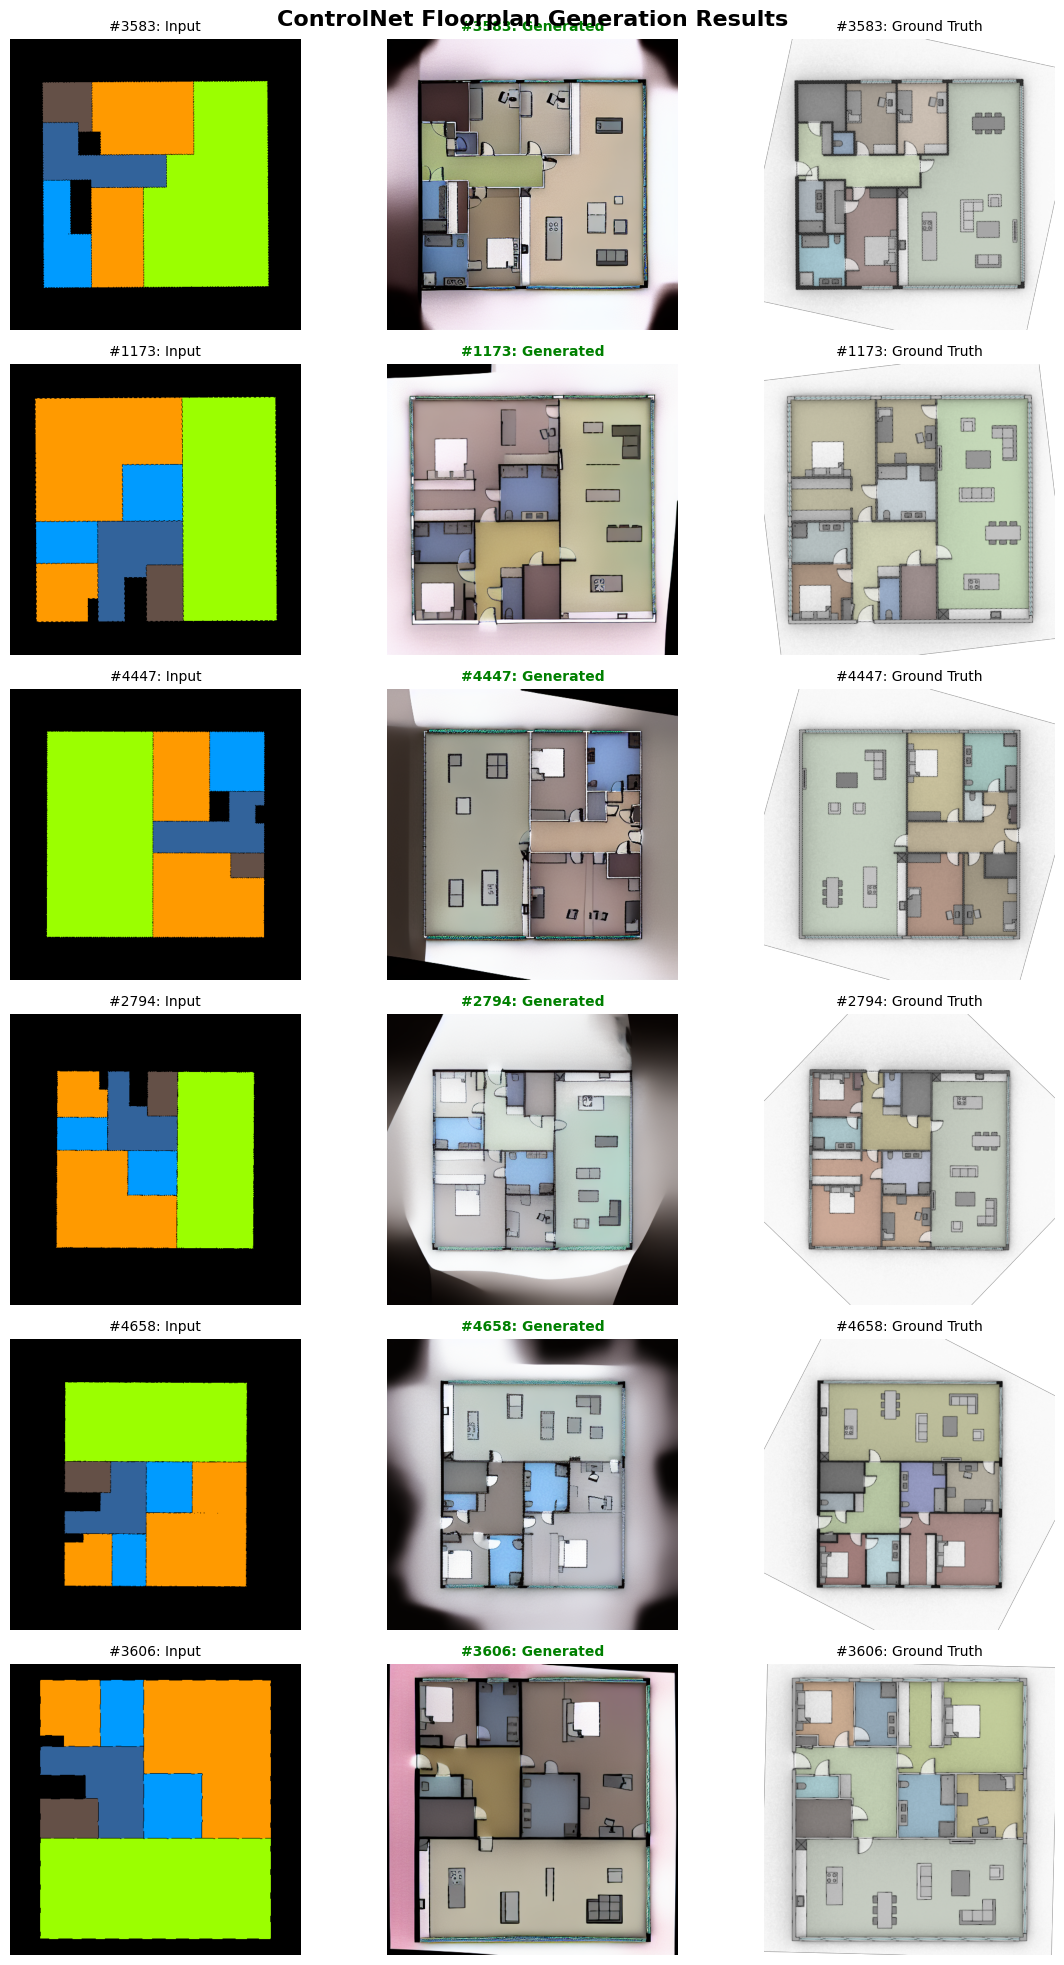


All test samples generated!
Saved: test_results.png


In [14]:
# Test on 6 samples
fig, axes = plt.subplots(6, 3, figsize=(12, 20))

print("Generating 6 test samples...\n")

for i in range(6):
    idx = random.randint(0, len(dataset)-1)
    sample = dataset[idx]

    # Generate
    gen_img = pipe(
        prompt=sample['captions'],
        image=sample['colors'],
        num_inference_steps=20,
        controlnet_conditioning_scale=CONTROLNET_CONDITIONING_SCALE,
        generator=torch.manual_seed(42+i)
    ).images[0]

    # Input
    axes[i,0].imshow(sample['colors'])
    axes[i,0].set_title(f"#{idx}: Input", fontsize=10)
    axes[i,0].axis('off')

    # Generated
    axes[i,1].imshow(gen_img)
    axes[i,1].set_title(f"#{idx}: Generated", fontsize=10, color='green', fontweight='bold')
    axes[i,1].axis('off')

    # Ground truth
    axes[i,2].imshow(sample['plans'])
    axes[i,2].set_title(f"#{idx}: Ground Truth", fontsize=10)
    axes[i,2].axis('off')

    print(f"Sample #{idx}: Generated")

plt.suptitle('ControlNet Floorplan Generation Results', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('test_results.png', dpi=200, bbox_inches='tight')
plt.show()

print("\nAll test samples generated!")
print("Saved: test_results.png")

🎨 Generating examples for AI54 Report Section 5.2...



Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating 4 examples for report...

Example 1: Sample #2591


  0%|          | 0/20 [00:00<?, ?it/s]

Example 2: Sample #3230


  0%|          | 0/20 [00:00<?, ?it/s]

Example 3: Sample #6470


  0%|          | 0/20 [00:00<?, ?it/s]

Example 4: Sample #7363


  0%|          | 0/20 [00:00<?, ?it/s]

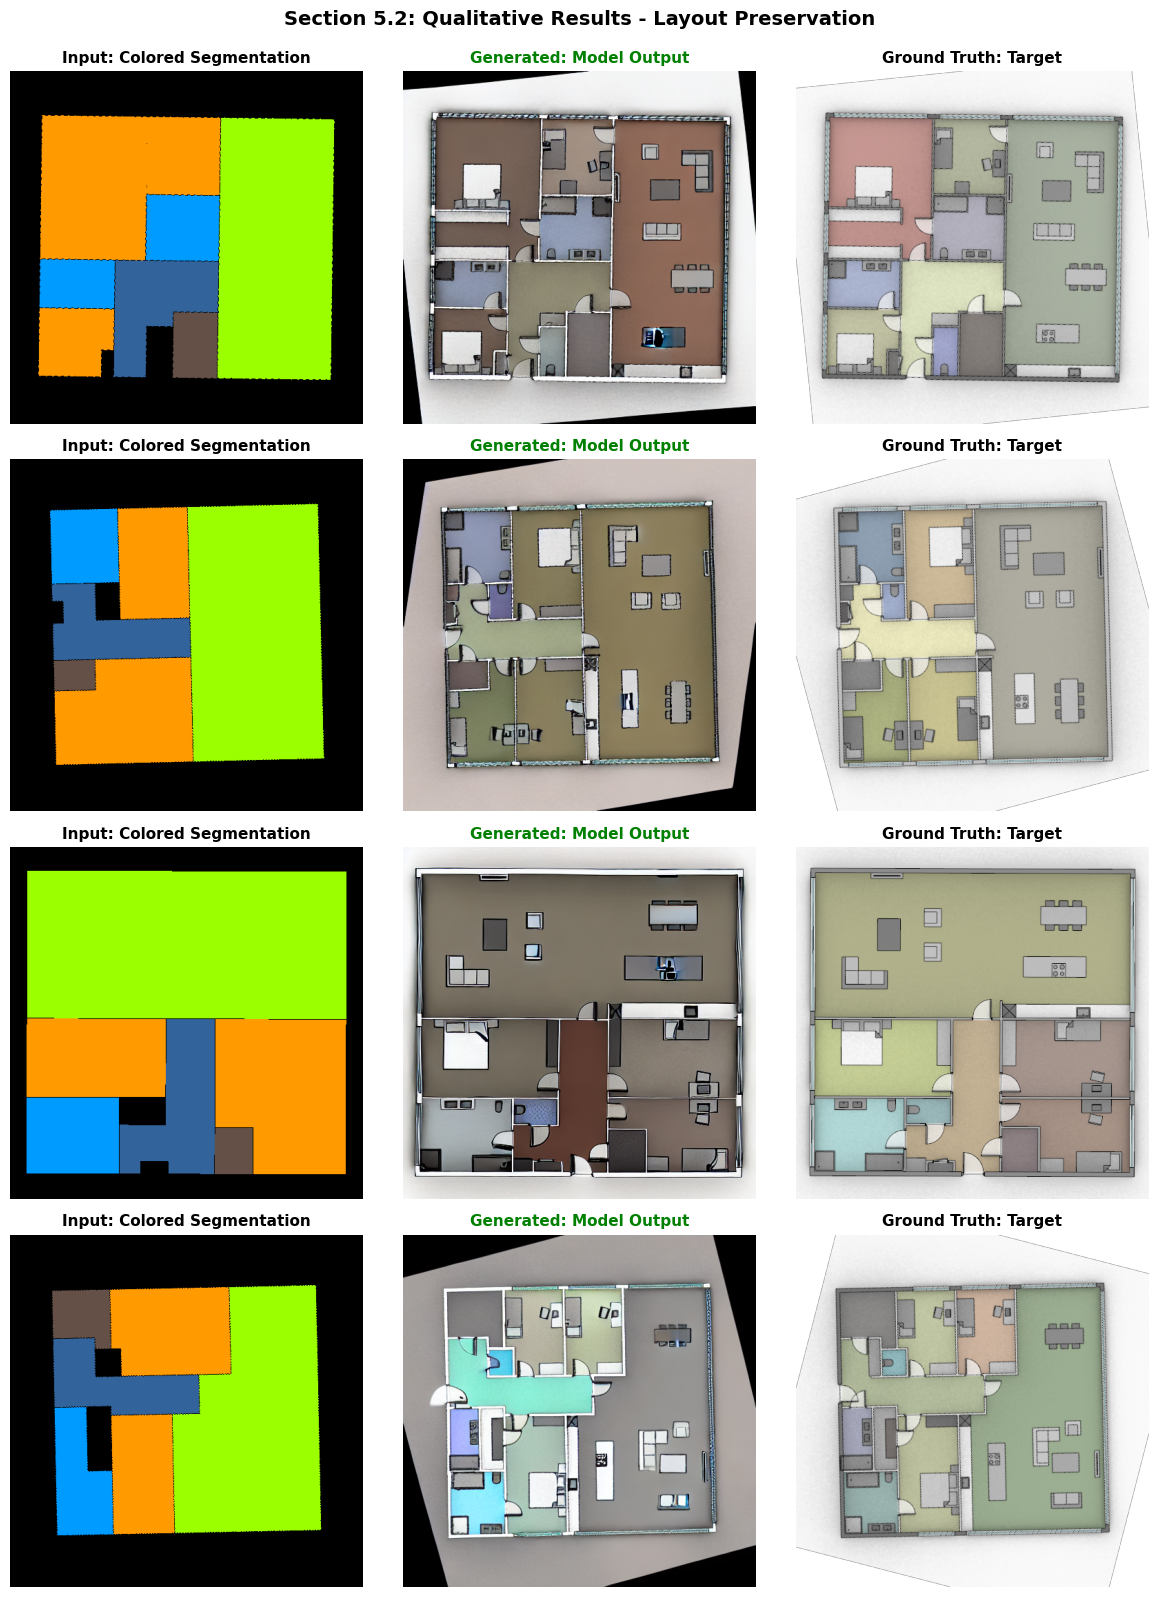


✅ Examples generated!
📸 Saved: ai54_section_5_2_examples.png

💡 Use this image in your report Section 5.2


In [ ]:
# =============================================================================
# GENERATE EXAMPLES FOR REPORT (Section 5.2)
# =============================================================================

print("Generating examples for AI54 Report Section 5.2...\n")

import random
import matplotlib.pyplot as plt
from PIL import Image

# Load model (if not already loaded)
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained(
    "Qistinasofea/controlnet-floorplan",
    torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16
).to('cuda')

# Load dataset
from datasets import load_dataset
dataset = load_dataset("Qistinasofea/floorplan-12k-aligned", split="train")

# Generate 4 diverse examples
print("Generating 4 examples for report...\n")

fig, axes = plt.subplots(4, 3, figsize=(12, 16))

for i in range(4):
    idx = random.randint(0, len(dataset)-1)
    sample = dataset[idx]

    print(f"Example {i+1}: Sample #{idx}")

    # Generate
    gen_img = pipe(
        prompt=sample['captions'],
        image=sample['colors'],
        num_inference_steps=20,
        controlnet_conditioning_scale=1.0,
        generator=torch.manual_seed(42+i)
    ).images[0]

    # Input
    axes[i,0].imshow(sample['colors'])
    axes[i,0].set_title(f"Input: Colored Segmentation", fontsize=11, fontweight='bold')
    axes[i,0].axis('off')

    # Generated
    axes[i,1].imshow(gen_img)
    axes[i,1].set_title(f"Generated: Model Output", fontsize=11, fontweight='bold', color='green')
    axes[i,1].axis('off')

    # Ground truth
    axes[i,2].imshow(sample['plans'])
    axes[i,2].set_title(f"Ground Truth: Target", fontsize=11, fontweight='bold')
    axes[i,2].axis('off')

plt.suptitle('Section 5.2: Qualitative Results - Layout Preservation',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('ai54_section_5_2_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nExamples generated!")
print("Saved: ai54_section_5_2_examples.png")
print("\nUse this image in your report Section 5.2")


### **4. Training Strategy**

#### **4.1 Architecture**

**The architecture explicitly separates structure from appearance:**

- **Base Model:** Stable Diffusion 1.5 (pre-trained, frozen)
  - Handles generation of realistic textures and appearance
  - Weights remain frozen to preserve pre-trained knowledge
  - 860M parameters (not trained)
  
- **Conditioning Model:** ControlNet Segmentation variant
  - Guides spatial structure based on colored segmentation masks
  - Fully fine-tuned for maximum adaptation capacity
  - 361M parameters (100% trainable)

**Progressive Training Strategy:**

1. ✅ **Full ControlNet Fine-Tuning** (CHOSEN)
   - **Rationale:** Dataset size (7394 samples) sufficient for full training
   - **Advantage:** Maximum model capacity, superior quality expected
   - **Optimization:** Gradient checkpointing enables training on T4 GPU (16GB VRAM)
   - **Parameters:** All 361M ControlNet parameters trainable
   - **Training time:** ~6 hours on T4 (acceptable for project scope)
---

#### **4.2 Hyperparameters (1 pt)**

**We explicitly define and justify the following training parameters:**

- **Learning Rate:** 1e-5
  - Lower than LoRA (1e-4) due to training full model
  - Standard for full ControlNet fine-tuning
  - Prevents instability when updating 361M parameters

- **Batch Size:** 4 (effective batch = 16 with gradient accumulation)
  - Per-GPU batch size: 4 (optimal for T4 16GB)
  - Gradient accumulation steps: 4
  - Effective batch size: 16 (for training stability)

- **Training Steps:** 7000
  - Equivalent to ~3-4 epochs on 7000 samples
  - Sufficient for full convergence
  - Checkpoints saved every 250 steps

- **Resolution:** 512 × 512
  - Matches preprocessed dataset resolution
  - Optimal for Stable Diffusion 1.5 architecture

- **Gradient Checkpointing:** Enabled
  - **Critical** for fitting 361M parameters in 16GB VRAM

---

#### **4.3 Configurations (1 pt)**

✅ **All parameters stored in configuration file** (`training_config.yaml`)  
✅ **Training is fully reproducible**  
✅ **Clear separation between codebase and experimental settings**

Configuration includes:
- Training method (full fine-tuning)
- Dataset name and version
- Model architectures
- All hyperparameters
- Optimization settings
- Trainable parameter count

---

### **Technical Advantages:**

**Full Fine-Tuning Benefits:**
- ✅ 100% of ControlNet parameters trained (361M)
- ✅ Maximum model capacity for complex spatial relationships
- ✅ Expected superior quality vs LoRA
- ✅ Dataset size (7394) fully supports this approach
- ✅ Gradient checkpointing makes it VRAM-feasible on T4

It works